In [1]:
from igraph import *
import json
import random
import numpy as np
from numpy import linalg
import itertools
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay  
import os
import pandas as pd
from copy import deepcopy

In [2]:
geo_file = "data/los_angeles_censustracts.json"
time_file = "data/los_angeles-censustracts-2019-4-All-MonthlyAggregate.csv"
os.makedirs ("./figs", exist_ok=True)

In [3]:
with open(geo_file) as geojson:
    census_tracts = json.loads(geojson.readline())

In [4]:
names = dict()
coordinates = dict()


for feat in census_tracts['features']:
    id = int(feat['properties']['MOVEMENT_ID'])
    name_ = feat['properties']['DISPLAY_NAME']
    names[id] = name_
    a = feat['geometry']['coordinates'][0]
    coordinates[id] = np.array(a if type(a[0][0]) == float else a[0]).mean(axis=0)

In [5]:
g = Graph(directed=False)
g.add_vertices(len(names))
g.vs['display_name'] = list(names.values())  # index = id - 1
g.vs['coordinates'] = list(coordinates.values())

In [6]:
month_filter = 12

edges = []
weights = []

with open(time_file) as f:
    f.readline()  # skip the first line
    while True:
        line = f.readline()
        if not line or line == '':
            break
    
        line = line.strip().split(',')

      
        src, dest, month, dist = int(line[0]), int(line[1]), int(line[2]), float(line[3])


        if month == month_filter:

            edges.append((src - 1, dest - 1))
            weights.append(dist)


In [7]:
g.add_edges(edges)
g.es['weight'] = weights

components = g.components()
gcc = max(components, key=len)
vs_to_delete = [i for i in range(len(g.vs)) if i not in gcc]
g.delete_vertices(vs_to_delete)

# remove duplicate edges
g = g.simplify(combine_edges=dict(weight='mean'))  # combine duplicate edges

In [8]:
print(len(g.vs), len(g.es))

2649 1003858


In [9]:
mst = g.spanning_tree(weights=g.es['weight'])

In [10]:
from geopy.geocoders import Nominatim

# Function to get street address near a location given its latitude and longitude
def get_street_address(lat, lon):
    geolocator = Nominatim(user_agent="my_geocoder")
    location = geolocator.reverse((lat, lon), exactly_one=True)
    if location:
        return location.address
    return None

count = 0
for e in mst.es:
    print("edge: ", mst.vs[e.source]['display_name'], mst.vs[e.target]['display_name'])
    source_centroid = mst.vs[e.source]['coordinates']
    target_centroid =  mst.vs[e.target]['coordinates']
    source_address = get_street_address(source_centroid[1], source_centroid[0])
    target_address = get_street_address(target_centroid[1], target_centroid[0])
    print("source address: ", source_address)
    print("target address: ", target_address)
    
    print("--------------")
    count += 1
    if count > 10:
        break

edge:  Census Tract 480302 Census Tract 480304
source address:  Sacred Heart Retreat House - Saint Joseph Campus, 507, North Granada Avenue, Alhambra, Los Angeles County, California, 91801, United States
target address:  269, Woodward Avenue, Alhambra, Los Angeles County, California, 91801, United States
--------------
edge:  Census Tract 480302 Census Tract 481002
source address:  Sacred Heart Retreat House - Saint Joseph Campus, 507, North Granada Avenue, Alhambra, Los Angeles County, California, 91801, United States
target address:  320, Cordova Street, Alhambra, Los Angeles County, CAL Fire Southern Region, California, 91801, United States
--------------
edge:  Census Tract 480303 Census Tract 480304
source address:  402, North Marguerita Avenue, Alhambra, Los Angeles County, California, 91801, United States
target address:  269, Woodward Avenue, Alhambra, Los Angeles County, California, 91801, United States
--------------
edge:  Census Tract 480303 Census Tract 480400
source addre

In [11]:
def get_sample_triangles(g, n_samples = 1000):
    res = []
    vertices = list(g.vs())
    i = 0
    while i < n_samples:
        tri_vs = random.sample(vertices, 3)
        tri_ids = [v.index for v in tri_vs]
        count = 0
        for j in range(3):
            for k in range(j):
                edge = g.get_eid(tri_ids[k], tri_ids[j], directed=False, error=False)
                if edge != -1:
                    count += 1
        if count == 3:
            res.append(tri_ids)
            i += 1
    return res

In [12]:
sampled_triangles = get_sample_triangles(g)
satifieds = 0
for triangle in sampled_triangles:
    e_lens = []
    for i in range(3):
        for j in range(i):
            e_lens.append(min(g.es.select(_between=([triangle[i]], [triangle[j]]))['weight']))
    # check if the triangle holds
    e_lens.sort()
    if e_lens[0] + e_lens[1] > e_lens[2]:
        satifieds += 1
print("Triangle inequality holds by {}%".format(satifieds / len(sampled_triangles) * 100))
        # print("Triangle {} is not degenerate".format(triangle))

Triangle inequality holds by 91.7%


## Question 12

In [13]:
def get_eulerian_tour(m_g):
    tour = []
    stack = [0]
    while stack:
        v = stack[-1]
        
        if m_g.degree(v) == 0:
            tour.append(v)
            stack.pop()
        else:
            u = m_g.neighbors(v)[0] 
            stack.append(u)
            m_g.delete_edges([(v, u)])
    return tour[::-1]

        

vertex_ids = {v: i for i, v in enumerate(mst.vs)}

multigraph = Graph(directed=True)
multigraph.add_vertices(len(vertex_ids))

for edge in mst.es:
    source, target = edge.source, edge.target
    multigraph.add_edges([(source, target), (target, source)])

eulerian_tour = get_eulerian_tour(multigraph)


tour_ = []
visited = set()
for node in eulerian_tour:
    if node not in visited:
        tour_.append(node)
        visited.add(node)

tsp = tour_[:-1]  # Remove the duplicate final node
print('IDs:\n' + '-' * 10 + '\n' + '\n'.join([mst.vs[i]['display_name'] for i in tsp]))

IDs:
----------
Census Tract 480302
Census Tract 480304
Census Tract 480303
Census Tract 480400
Census Tract 480500
Census Tract 480804
Census Tract 480704
Census Tract 480704
Census Tract 480703
Census Tract 201120
Census Tract 201501
Census Tract 201503
Census Tract 201401
Census Tract 201200
Census Tract 201110
Census Tract 201301
Census Tract 199110
Census Tract 199120
Census Tract 199202
Census Tract 199201
Census Tract 199800
Census Tract 201504
Census Tract 480704
Census Tract 480500
Census Tract 480703
Census Tract 480702
Census Tract 183702
Census Tract 183103
Census Tract 183104
Census Tract 183101
Census Tract 183220
Census Tract 183221
Census Tract 183222
Census Tract 181500
Census Tract 183620
Census Tract 183610
Census Tract 480600
Census Tract 183104
Census Tract 463900
Census Tract 464000
Census Tract 183702
Census Tract 183701
Census Tract 183820
Census Tract 183810
Census Tract 183520
Census Tract 183510
Census Tract 186203
Census Tract 185100
Census Tract 199400
Cens

In [14]:
mst_cost = sum(mst.es['weight'])
hop_distances = []
for i in range(len(tsp) - 1):
    edge_index = g.get_eid(tsp[i], tsp[i + 1], directed=False, error=False)
    hop_distances.append(g.es[edge_index]['weight'])

print('Hop distances:\n' + '-' * 10 + '\n' +
      '\n'.join(['{:.3f}'.format(x) for x in hop_distances]))

Hop distances:
----------
129.765
90.235
126.475
125.160
91.785
60.910
87.115
43.330
68.810
130.045
117.430
97.520
88.940
121.045
219.300
122.560
101.975
185.285
116.045
96.300
613.815
485.570
127.635
243.310
115.820
91.310
58.075
63.395
114.085
104.440
109.100
77.220
87.820
338.830
100.195
428.130
140.670
78.305
175.055
380.025
68.525
82.645
108.085
110.405
84.215
98.150
157.270
71.385
92.435
82.635
91.390
84.445
241.260
146.690
179.660
568.025
121.495
397.170
84.635
243.805
83.080
73.635
61.540
60.360
45.455
53.030
67.820
52.470
44.020
94.160
78.885
70.305
101.305
97.930
112.880
133.095
135.995
115.225
129.880
101.210
115.790
143.455
235.365
79.545
57.410
78.845
61.860
55.235
60.085
44.215
91.140
120.360
156.935
154.350
140.325
135.730
235.970
131.585
109.775
381.465
99.745
130.065
179.295
190.030
157.105
131.875
129.210
114.380
138.635
128.245
327.830
124.405
129.410
373.715
127.630
470.780
129.195
380.145
103.385
87.600
128.645
113.630
110.490
99.990
146.310
348.865
134.685
142.590

In [15]:
tsp_cost = sum(hop_distances)
print('MST Cost:', mst_cost)
print('TSP Cost:', tsp_cost)
print('Ratio: %.2f'% ( tsp_cost/mst_cost ) )

MST Cost: 269084.5449999994
TSP Cost: 438291.2350000002
Ratio: 1.63


## Question 13

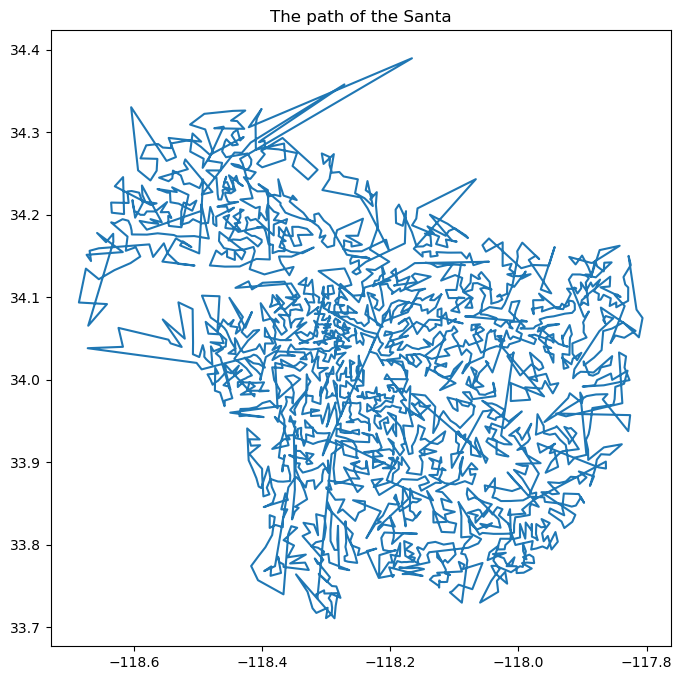

In [16]:
all_coordinates = np.array(g.vs['coordinates'])
tsp_coordinates = all_coordinates[tsp, :]
tsp_coordinates = np.vstack([tsp_coordinates, tsp_coordinates[0, :]])

plt.figure(figsize=(8,8))
plt.plot(tsp_coordinates[:, 0], tsp_coordinates[:, 1],'-')
plt.title("The path of the Santa")
plt.savefig("figs/path_of_santa_q13.png")
plt.show()

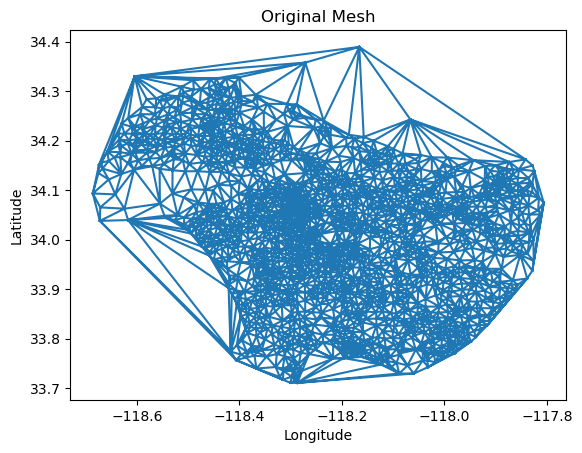

In [17]:
points = np.array(g.vs['coordinates'])
tri = Delaunay(points)

#use the Delaunay function imported above
plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.title("Original Mesh")
plt.savefig("figs/original_mesh_q14.png")
plt.show()

In [18]:

edge_dict = {(min(e.tuple[0], e.tuple[1]), max(e.tuple[0], e.tuple[1])): e.index for e in g.es}


edges_to_induce = []

for i in range(tri.simplices.shape[0]):
    for col1, col2 in ((0, 1), (1, 2), (0, 2)):
        v1 = tri.simplices[i, col1]
        v2 = tri.simplices[i, col2]
        
        # Ensure vertices are in order (smaller, larger)
        v_small, v_large = min(v1, v2), max(v1, v2)

        # Check if the corresponding edge exists in the original graph
        if (v_small, v_large) in edge_dict:
            edges_to_induce.append(edge_dict[(v_small, v_large)])

# Create a subgraph based on these edges
tri_g = g.subgraph_edges(edges_to_induce, delete_vertices=False)

## Esmitate the traffic flow

In [19]:
edge_ends = tri_g.get_edgelist()
sources, targets = [item[0] for item in edge_ends],[item[1] for item in edge_ends]

In [20]:
edge_ends = tri_g.get_edgelist()
edge_ends
array1 = tri_g.vs[sources]['coordinates']
array2 = tri_g.vs[targets]['coordinates']
result = [a1 - a2 for a1, a2 in zip(array1, array2)]
distance = [69 * np.sqrt(np.sum(np.square(d))) for d in result]
travel_time = tri_g.es['weight']
speeds =  np.array(distance) / np.array(travel_time) * 3600
car_length = 0.003
safety_distances = speeds * (2/3600)
n_lanes = 2
cars_per_mile = distance/(safety_distances+car_length)*n_lanes
cars_per_hour = cars_per_mile * np.array(speeds)

In [21]:
np.mean(cars_per_hour)

2428.8317371061644

In [22]:
tri_g.es['capacity'] = cars_per_hour

In [23]:
malibu = [-118.56, 34.04]  # malibu
long_beach = [-118.18, 33.77]  # long beach
min_malibu=np.inf
min_long_beach=np.inf
long_beach_node=0
malibu_node=0

for i in range(1,len(points[:,0])):
    long_beach_closest=np.sqrt(((points[i][0])-long_beach[0])**2+((points[i][1])-long_beach[1])**2)
    malibu_closest=np.sqrt((malibu[0]-points[i][0])**2+(malibu[1]-points[i][1])**2)
    if long_beach_closest<min_long_beach:
        min_long_beach=long_beach_closest
        long_beach_node=i
    if malibu_closest<min_malibu:
        min_malibu=malibu_closest
        malibu_node=i
        

print(malibu_node, long_beach_node)

1511 660


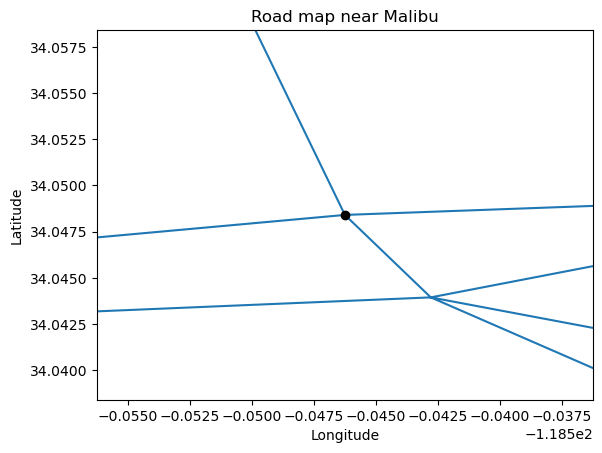

In [24]:
plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.ylim(points[malibu_node][1]-0.01,points[malibu_node][1]+0.01)
plt.xlim(points[malibu_node][0]-0.01,points[malibu_node][0]+0.01)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Road map near Malibu')
plt.plot(points[malibu_node][0], points[malibu_node][1],'o',color='black')
plt.savefig('figs/malibu_q16.png')
plt.show()

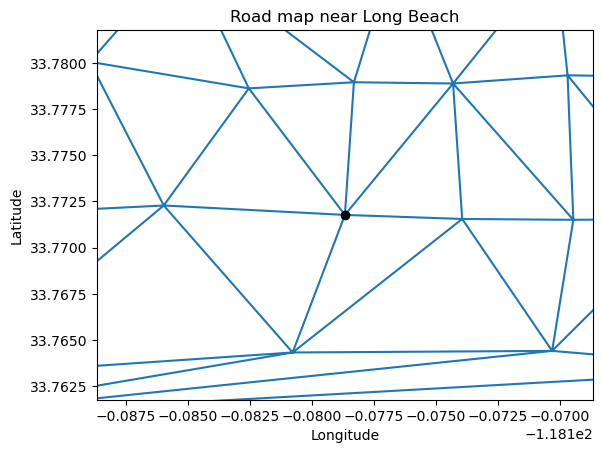

In [25]:
plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.ylim(points[long_beach_node][1]-0.01,points[long_beach_node][1]+0.01)
plt.xlim(points[long_beach_node][0]-0.01,points[long_beach_node][0]+0.01)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Road map near Long Beach')
plt.plot(points[long_beach_node][0], points[long_beach_node][1],'o',color='black')
plt.savefig('figs/long_beach_q16.png')
plt.show()

In [26]:
print('Number of independent roads:',tri_g.edge_disjoint_paths(malibu_node,long_beach_node) ) #max flow of graph (inbuilt is okay )
print('Number of cars per hour:',tri_g.maxflow(malibu_node, long_beach_node, 'capacity').value )

Number of independent roads: 4
Number of cars per hour: 7579.860651821042


## Prune the network

In [27]:
trim_thresh = 800
edges_to_induce = tri_g.es.select(weight_le=trim_thresh)
tri_g_trimmed = tri_g.subgraph_edges(edges_to_induce)

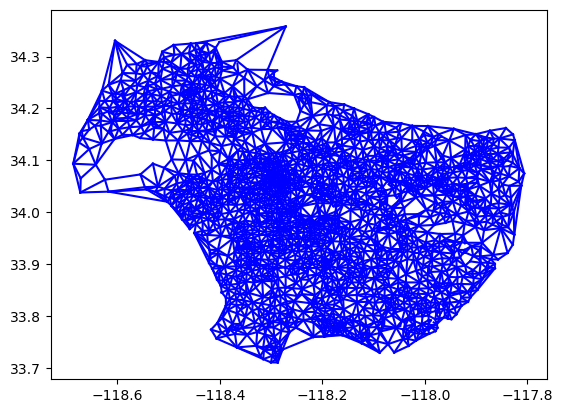

In [44]:

for e in tri_g_trimmed.es:
    v1 = tri_g_trimmed.vs[e.source]['coordinates']
    v2 = tri_g_trimmed.vs[e.target]['coordinates']
    temp = np.vstack([v1, v2])
    x, y = temp[:, 0], temp[:, 1]
    plt.plot(x, y, 'blue')
plt.savefig("figs/pruned_mesh.png")


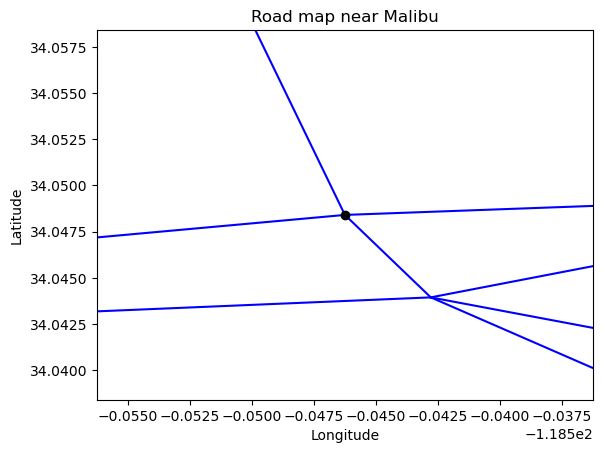

In [29]:

for e in tri_g_trimmed.es:
    v1 = tri_g_trimmed.vs[e.source]['coordinates']
    v2 = tri_g_trimmed.vs[e.target]['coordinates']
    temp = np.vstack([v1, v2])
    x, y = temp[:, 0], temp[:, 1]
    plt.plot(x, y, 'blue')

plt.ylim(points[malibu_node][1]-0.01,points[malibu_node][1]+0.01)
plt.xlim(points[malibu_node][0]-0.01,points[malibu_node][0]+0.01)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Road map near Malibu')
plt.plot(points[malibu_node][0], points[malibu_node][1],'o',color='black')
plt.savefig('figs/malibu_q18.png')
plt.show()

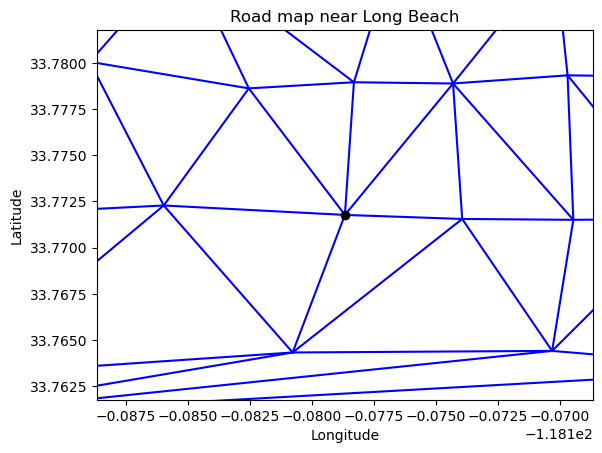

In [30]:

for e in tri_g_trimmed.es:
    v1 = tri_g_trimmed.vs[e.source]['coordinates']
    v2 = tri_g_trimmed.vs[e.target]['coordinates']
    temp = np.vstack([v1, v2])
    x, y = temp[:, 0], temp[:, 1]
    plt.plot(x, y, 'blue')

plt.ylim(points[long_beach_node][1]-0.01,points[long_beach_node][1]+0.01)
plt.xlim(points[long_beach_node][0]-0.01,points[long_beach_node][0]+0.01)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Road map near Long Beach')
plt.plot(points[long_beach_node][0], points[long_beach_node][1],'o',color='black')
plt.savefig('figs/long_beach_q18.png')
plt.show()

In [31]:
print('Number of independent roads:',tri_g_trimmed.edge_disjoint_paths(malibu_node,long_beach_node) ) #max flow of graph (inbuilt is okay )
print('Number of cars per hour:',tri_g_trimmed.maxflow(malibu_node, long_beach_node, 'capacity').value )

Number of independent roads: 4
Number of cars per hour: 7579.860651821042


## Construct new roads

In [32]:

tri_g_copied = tri_g_trimmed.copy()

for e in tri_g_copied.es:
     # Get the source and target vertices of the edge
    source_vertex = e.source
    target_vertex = e.target
    
    # Get the coordinates of the source and target vertices
    source_coordinates = tri_g_trimmed.vs[source_vertex]['coordinates']
    target_coordinates = tri_g_trimmed.vs[target_vertex]['coordinates']

    # Calculate the geodesic distance between the two vertices
    distance = np.sqrt(
        (source_coordinates[0] - target_coordinates[0]) ** 2 
                       + 
                       (source_coordinates[1] - target_coordinates[1]) ** 2
                       ) 
    
    # Update the weight of the edge
    e['distance'] = distance

In [33]:
import networkx as nx
from tqdm import tqdm

def compute_single_edge_distance(i, j, lons, lats):
    x1, y1 = lons[i], lats[i]
    x2, y2 = lons[j], lats[j]
    return np.sqrt((x1-x2)**2 + (y1-y2)**2)

def get_sorted_extra_distances(G, dist_matrix, lons, lats):
    
    # def compute_single_edge_distance(i, j):
    #     x1, y1 = lons[i], lats[i]
    #     x2, y2 = lons[j], lats[j]
    #     return np.sqrt((x1-x2)**2 + (y1-y2)**2)
        
    # add weights to network G
    G_nx = G.to_networkx()
    attrs = {}

    nx.set_edge_attributes(G_nx, attrs)
    
    # calculate extra distances for all pairs
    n_node = len(G_nx)
    extra_distances = []
    inf = 1e6  # if there is no path, set to a large value

    for i in tqdm(range(n_node-1)):
        for j in range(i+1, n_node):
            extra_distance = (
                dist_matrix[i][j]
                - compute_single_edge_distance(i, j, lons, lats)
            )
            extra_distances.append((extra_distance, i, j))
    
    return sorted(extra_distances, reverse=True)


def print_coordinates_and_plot(G, arr, longitudes, latitudes, save_path = None ):
    for e in G.es:
        v1 = G.vs[e.source]['coordinates']
        v2 = G.vs[e.target]['coordinates']
        temp = np.vstack([v1, v2])
        x, y = temp[:, 0], temp[:, 1]
        # print(x, y)
        plt.plot(x, y, 'blue')
    
    for i, (_, s, t) in enumerate(arr):
        x1, x2 = longitudes[s], longitudes[t]
        y1, y2 = latitudes[s], latitudes[t]
        print(f"\nedge {i+1}: ({y1}, {x1}) - ({y2}, {x2})")
        
        plt.plot([y1, y2], [x1, x2],  'red')
    plt.ylabel('Latitude')
    plt.xlabel('Longitudes')
    plt.title('Road Network with New Edges')
    plt.legend()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

/tmp/ipykernel_242673/2451403124.py:2: DeprecationWarning: Graph.shortest_paths() is deprecated; use Graph.distances() instead
  dist_matrix = tri_g_copied.shortest_paths(weights = 'distance')
100%|██████████| 2646/2646 [00:02<00:00, 1093.39it/s]


Top 20 pairs with highest extra distance: (distance, v, s)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



edge 1: (-118.41714115454548, 33.774103109090916) - (-118.67145511923503, 34.06533878290219)

edge 2: (-117.84197423684212, 34.16224818421053) - (-118.27158981797648, 34.35782482248528)

edge 3: (-118.40648371022725, 33.75689578693178) - (-118.67145511923503, 34.06533878290219)

edge 4: (-117.82810402090584, 34.1499674041812) - (-118.27158981797648, 34.35782482248528)

edge 5: (-117.8732378168498, 34.15698468864466) - (-118.27158981797648, 34.35782482248528)

edge 6: (-118.67225393333337, 34.03809095384618) - (-118.41714115454548, 33.774103109090916)

edge 7: (-117.83331135955059, 34.11532583146067) - (-118.27158981797648, 34.35782482248528)

edge 8: (-117.82866074137928, 34.111707206896554) - (-118.27158981797648, 34.35782482248528)

edge 9: (-117.82467288479266, 34.13885138248847) - (-118.27158981797648, 34.35782482248528)

edge 10: (-118.67225393333337, 34.03809095384618) - (-118.40648371022725, 33.75689578693178)

edge 11: (-117.88665511320752, 34.12443260377358) - (-118.271589817

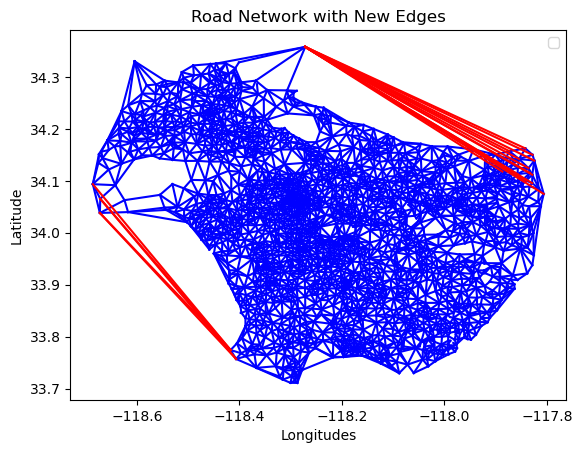

In [34]:
k = 20
dist_matrix = tri_g_copied.shortest_paths(weights = 'distance')
points = np.array(tri_g_copied.vs['coordinates'])

lats = points[:,0]
lons = points[:,1]

extra_dist = get_sorted_extra_distances(tri_g_copied, dist_matrix, lons=lons, lats=lats)

extra_dist_topk = extra_dist[:k]
print("Top 20 pairs with highest extra distance: (distance, v, s)")
# print(extra_dist_topk)
print_coordinates_and_plot(tri_g_copied, extra_dist_topk, longitudes=lons, latitudes=lats, save_path="figs/new_roads_q19.png")

100%|██████████| 3501981/3501981 [00:01<00:00, 1987344.12it/s]


Top 20 pairs with highest weighted extra distance: (distance, v, s)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



edge 1: (-117.84197423684212, 34.16224818421053) - (-118.27158981797648, 34.35782482248528)

edge 2: (-117.81570633399605, 34.084863258449296) - (-118.27158981797648, 34.35782482248528)

edge 3: (-118.67225393333337, 34.03809095384618) - (-118.40648371022725, 33.75689578693178)

edge 4: (-117.8497316851852, 34.102625592592595) - (-118.27158981797648, 34.35782482248528)

edge 5: (-117.84852660194171, 34.05349977669904) - (-118.27158981797648, 34.35782482248528)

edge 6: (-117.8913622021277, 34.13688211702129) - (-118.27158981797648, 34.35782482248528)

edge 7: (-117.91813289473686, 34.10397986842105) - (-118.27158981797648, 34.35782482248528)

edge 8: (-117.90235906172836, 34.1102980617284) - (-118.27158981797648, 34.35782482248528)

edge 9: (-118.57981584070802, 34.175763982300886) - (-118.55510068503939, 34.07289098425196)

edge 10: (-117.87031364705881, 34.08334876470588) - (-118.27158981797648, 34.35782482248528)

edge 11: (-118.63048660074622, 34.1327155932836) - (-118.41714115454

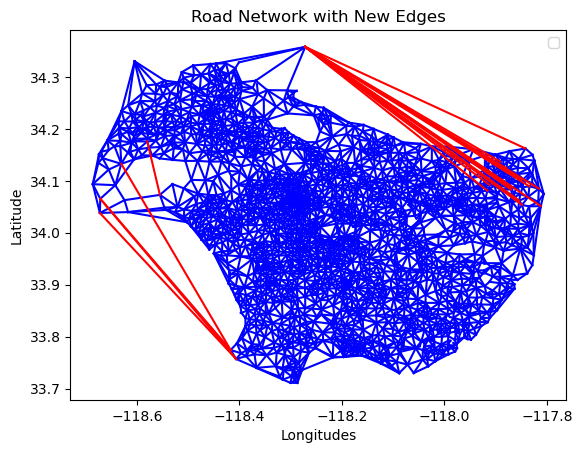

In [35]:
weighted_extra_distances = [
    (extra_distance*random.randint(1, 1000), i, j)
    for extra_distance, i, j in tqdm(extra_dist)
]
weighted_extra_dist_topk = sorted(weighted_extra_distances, reverse=True)[:k]
print("Top 20 pairs with highest weighted extra distance: (distance, v, s)")
# print(weighted_extra_distances_topk)
print_coordinates_and_plot(tri_g_copied, weighted_extra_dist_topk, longitudes=lons, latitudes=lats, save_path="figs/new_roads_q20.png")
# plot_graph_with_new_roads(weighted_extra_distances_topk)

In [36]:
tri_g1 = tri_g_copied.copy()

added_edge = []
dist_matrix = tri_g1.shortest_paths(weights='distance')

for i in range(20):
    extra_dist = get_sorted_extra_distances(tri_g_copied, dist_matrix, lons=lons, lats=lats)
    n_nodes = len(tri_g1.vs)
    added_edge.append(extra_dist[0])
    # print(extra_dist[0])
    source = extra_dist[0][1]
    target = extra_dist[0][2]
    
    distance = compute_single_edge_distance ( source, target, lons, lats)
    edge = tri_g1.add_edge(source, target)
    tri_g1.es[edge.index]['distance'] = distance
    dist_matrix = tri_g1.shortest_paths(weights='distance')

/tmp/ipykernel_242673/3385112239.py:4: DeprecationWarning: Graph.shortest_paths() is deprecated; use Graph.distances() instead
  dist_matrix = tri_g1.shortest_paths(weights='distance')
  0%|          | 0/2646 [00:00<?, ?it/s]

100%|██████████| 2646/2646 [00:02<00:00, 1093.23it/s]
/tmp/ipykernel_242673/3385112239.py:17: DeprecationWarning: Graph.shortest_paths() is deprecated; use Graph.distances() instead
  dist_matrix = tri_g1.shortest_paths(weights='distance')
100%|██████████| 2646/2646 [00:02<00:00, 1108.72it/s]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



edge 1: (-118.41714115454548, 33.774103109090916) - (-118.67145511923503, 34.06533878290219)

edge 2: (-117.84197423684212, 34.16224818421053) - (-118.27158981797648, 34.35782482248528)

edge 3: (-118.57609893103452, 34.163914112068966) - (-118.55510068503939, 34.07289098425196)

edge 4: (-117.90384881034481, 34.12744793103448) - (-118.27158981797648, 34.35782482248528)

edge 5: (-117.94347146212125, 34.160677848484866) - (-118.27158981797648, 34.35782482248528)

edge 6: (-117.99399975280905, 34.16600654494379) - (-118.27158981797648, 34.35782482248528)

edge 7: (-118.41714115454548, 33.774103109090916) - (-118.62418590723568, 34.06269522170691)

edge 8: (-118.046042942029, 34.17109230434782) - (-118.27158981797648, 34.35782482248528)

edge 9: (-118.10868277868856, 34.18016231147541) - (-118.27158981797648, 34.35782482248528)

edge 10: (-118.5556897357724, 34.143095296747944) - (-118.53067983104125, 34.09368131827117)

edge 11: (-118.66929280689664, 34.156163006896556) - (-117.9828818

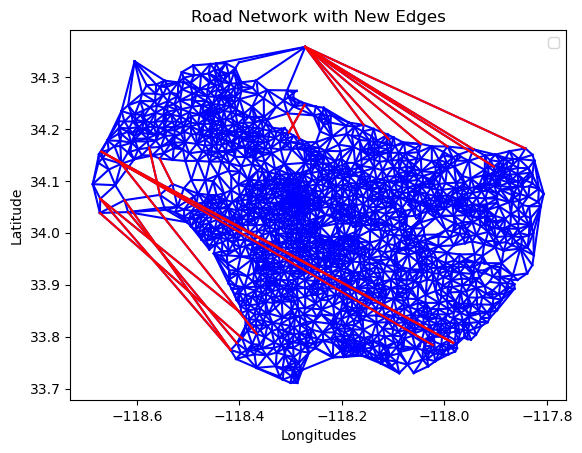

In [37]:
print_coordinates_and_plot(tri_g1, added_edge, longitudes=lons, latitudes=lats, save_path="figs/new_roads_q21.png")

In [38]:
tri_g_time = tri_g_trimmed.copy()
dist_matrix = tri_g_copied.shortest_paths(weights = 'distance')
for e in tri_g_time.es:
    # Get the source and target vertices of the edge
    source_vertex = e.source
    target_vertex = e.target
    
    # Get the coordinates of the source and target vertices
    source_coordinates = tri_g_trimmed.vs[source_vertex]['coordinates']
    target_coordinates = tri_g_trimmed.vs[target_vertex]['coordinates']

    # Calculate the geodesource_vertexsic distance between the two vertices
    distance = np.sqrt((source_coordinates[0] - target_coordinates[0]) ** 2 +
                (source_coordinates[1] - target_coordinates[1]) ** 2)
    time = e['weight']
    distance_st = dist_matrix[source_vertex][target_vertex]
    speed = distance_st/time
    time_direct = distance/speed
    time_extra = time - time_direct
    # Update the weight of the edge
    e['distance'] = distance
    e['distance_st'] = distance_st
    e['speed'] = speed
    e['time_extra'] = time_extra

/tmp/ipykernel_242673/896491803.py:2: DeprecationWarning: Graph.shortest_paths() is deprecated; use Graph.distances() instead
  dist_matrix = tri_g_copied.shortest_paths(weights = 'distance')


100%|██████████| 2646/2646 [00:02<00:00, 1005.56it/s]


[(1270.3895410723735, 1783, 2416), (1252.8631429260095, 1860, 2416), (1153.8889769479183, 1783, 2413), (1146.2778771962248, 1859, 2416), (1134.1965992778387, 1860, 2413), (1132.3580394431988, 1699, 1783), (1119.6690284556112, 1699, 1860), (1107.7052218590086, 985, 1678), (1104.5835299882676, 988, 1510), (1094.0169192124886, 1782, 2416), (1075.812196539635, 989, 1510), (1071.6095362416345, 144, 1783), (1053.8289562498721, 144, 1860), (1051.7197552248826, 430, 1783), (1044.4861781848101, 950, 1510), (1043.687810050943, 989, 1678), (1041.616826813589, 1882, 2416), (1034.078921859059, 430, 1860), (1032.7277657916725, 951, 1510), (1030.2237008168743, 984, 1678)]
Top 20 pairs with highest extra time: (time, v, s)
[(1270.3895410723735, 1783, 2416), (1252.8631429260095, 1860, 2416), (1153.8889769479183, 1783, 2413), (1146.2778771962248, 1859, 2416), (1134.1965992778387, 1860, 2413), (1132.3580394431988, 1699, 1783), (1119.6690284556112, 1699, 1860), (1107.7052218590086, 985, 1678), (1104.58352

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



edge 1: (-118.41714115454548, 33.774103109090916) - (-118.67145511923503, 34.06533878290219)

edge 2: (-118.40648371022725, 33.75689578693178) - (-118.67145511923503, 34.06533878290219)

edge 3: (-118.41714115454548, 33.774103109090916) - (-118.68599468727271, 34.09347549818183)

edge 4: (-118.39683944230771, 33.7679271025641) - (-118.67145511923503, 34.06533878290219)

edge 5: (-118.40648371022725, 33.75689578693178) - (-118.68599468727271, 34.09347549818183)

edge 6: (-118.67225393333337, 34.03809095384618) - (-118.41714115454548, 33.774103109090916)

edge 7: (-118.67225393333337, 34.03809095384618) - (-118.40648371022725, 33.75689578693178)

edge 8: (-118.6174550722892, 34.15459418072292) - (-118.53067983104125, 34.09368131827117)

edge 9: (-118.57017334070797, 34.14872431415929) - (-118.55510068503939, 34.07289098425196)

edge 10: (-118.40485093013112, 33.78694638427947) - (-118.67145511923503, 34.06533878290219)

edge 11: (-118.59018528030296, 34.14922015909091) - (-118.555100685

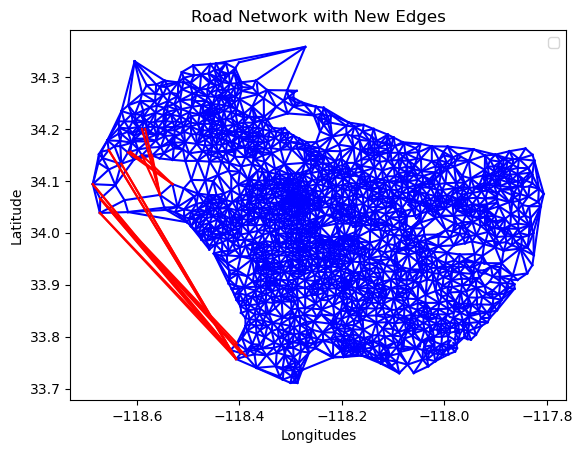

In [39]:
time_matrix = tri_g_time.distances(weights='weight')
def get_sorted_extra_distances_with_time(G, dist_matrix, time_matrix, lons, lats):
    
    # def compute_single_edge_distance(i, j):
    #     x1, y1 = lons[i], lats[i]
    #     x2, y2 = lons[j], lats[j]
    #     return np.sqrt((x1-x2)**2 + (y1-y2)**2)
        
    # add weights to network G
    G_nx = G.to_networkx()
    attrs = {}

    nx.set_edge_attributes(G_nx, attrs)
    
    # calculate extra distances for all pairs
    n_node = len(G_nx)
    extra_distances = []
    inf = 1e6  # if there is no path, set to a large value

    for i in tqdm(range(n_node-1)):
        for j in range(i+1, n_node):
            extra_distance = (
                time_matrix[i][j]
                - compute_single_edge_distance(i, j, lons, lats)/ (dist_matrix[i][j] / time_matrix[i][j])
            )
            extra_distances.append((extra_distance, i, j))
    
    return sorted(extra_distances, reverse=True)

# travel time matrix and travel distance matrix
k = 20
extra_times = get_sorted_extra_distances_with_time(tri_g_time, dist_matrix, time_matrix, lons=lons, lats=lats)
print(extra_times[:k])
extra_times_topk = extra_times[:k]
print("Top 20 pairs with highest extra time: (time, v, s)")
print(extra_times_topk)
print_coordinates_and_plot(tri_g_time, extra_times_topk, 
                           longitudes=lons, latitudes=lats, save_path="figs/new_roads_q22.png")

In [40]:
time_g1 = tri_g_time.copy()
added_edge = []
time_matrix = time_g1.distances(weights='weight')
dist_matrix = time_g1.shortest_paths(weights='distance')
for i in range(20):
    extra_times = get_sorted_extra_distances_with_time(time_g1, dist_matrix,
                                                       time_matrix, lons=lons, lats=lats)
    added_edge.append(extra_times[0])
    # add_1_edge(g1,extra_times)
    source = extra_times[0][1]
    target = extra_times[0][2]
    time_ = time_matrix[source][target] - extra_times[0][0]
    distance = compute_single_edge_distance ( source, target, lons, lats)
    
    edge = time_g1.add_edge(source, target, weight=time_, distance=distance)
    
    time_matrix = time_g1.distances(weights='weight')
    dist_matrix = time_g1.shortest_paths(weights='distance')

/tmp/ipykernel_242673/1648338199.py:4: DeprecationWarning: Graph.shortest_paths() is deprecated; use Graph.distances() instead
  dist_matrix = time_g1.shortest_paths(weights='distance')
100%|██████████| 2646/2646 [00:02<00:00, 1020.72it/s]
/tmp/ipykernel_242673/1648338199.py:18: DeprecationWarning: Graph.shortest_paths() is deprecated; use Graph.distances() instead
  dist_matrix = time_g1.shortest_paths(weights='distance')
100%|██████████| 2646/2646 [00:02<00:00, 1029.12it/s]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



edge 1: (-118.41714115454548, 33.774103109090916) - (-118.67145511923503, 34.06533878290219)

edge 2: (-118.6174550722892, 34.15459418072292) - (-118.53067983104125, 34.09368131827117)

edge 3: (-118.57017334070797, 34.14872431415929) - (-118.55510068503939, 34.07289098425196)

edge 4: (-117.84197423684212, 34.16224818421053) - (-118.27158981797648, 34.35782482248528)

edge 5: (-118.41714115454548, 33.774103109090916) - (-118.62418590723568, 34.06269522170691)

edge 6: (-117.89365872839508, 34.05103139506174) - (-118.27158981797648, 34.35782482248528)

edge 7: (-117.90384881034481, 34.12744793103448) - (-118.27158981797648, 34.35782482248528)

edge 8: (-117.94347146212125, 34.160677848484866) - (-118.27158981797648, 34.35782482248528)

edge 9: (-117.95946314285713, 33.94862083333332) - (-118.27158981797648, 34.35782482248528)

edge 10: (-118.01154852195125, 33.99293787317071) - (-118.27158981797648, 34.35782482248528)

edge 11: (-117.99399975280905, 34.16600654494379) - (-118.27158981

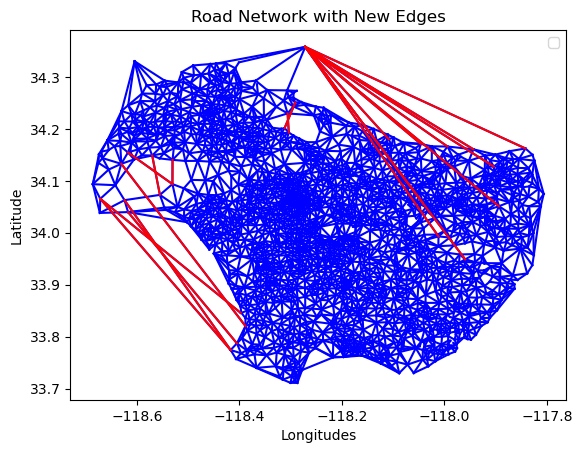

In [41]:
print_coordinates_and_plot(time_g1, added_edge, longitudes=lons, latitudes=lats, save_path="figs/new_roads_q23.png")

In [42]:
def get_sorted_extra_distances_with_weighted_time(G, dist_matrix, time_matrix, weight_matrix, lons, lats):
    
    # def compute_single_edge_distance(i, j):
    #     x1, y1 = lons[i], lats[i]
    #     x2, y2 = lons[j], lats[j]
    #     return np.sqrt((x1-x2)**2 + (y1-y2)**2)
        
    # add weights to network G
    G_nx = G.to_networkx()
    attrs = {}

    nx.set_edge_attributes(G_nx, attrs)
    
    # calculate extra distances for all pairs
    n_node = len(G_nx)
    extra_distances = []
    inf = 1e6  # if there is no path, set to a large value

    for i in tqdm(range(n_node-1)):
        for j in range(i+1, n_node):
            extra_distance = (
                time_matrix[i][j]
                - compute_single_edge_distance(i, j, lons, lats)/ (dist_matrix[i][j] / time_matrix[i][j])
            )
            extra_distance_weighted = extra_distance * weight_matrix[i][j]
            extra_distances.append((extra_distance_weighted, i, j))

    return sorted(extra_distances, reverse=True)

weighted_g1 = tri_g_time.copy()
n_nodes = len(weighted_g1.vs)
weight_matrix = [
    [ random.randint(1, 1000) for _ in range(n_nodes)]
    for _ in range(n_nodes)
]

weighted_g1 =  tri_g_time.copy()
added_edge = []
time_matrix = weighted_g1.distances(weights = 'weight')
dist_matrix = weighted_g1.distances(weights = 'distance')

for i in range(20):
    weighted_extra_times = get_sorted_extra_distances_with_weighted_time(weighted_g1, dist_matrix, 
                                                                         time_matrix, 
                                                                         weight_matrix,
                                                                         lons, lats)
    added_edge.append(weighted_extra_times[0])
    source = weighted_extra_times[0][1]
    target = weighted_extra_times[0][2]
    edge = weighted_g1.add_edge(source, target)
    
    weight = time_matrix[source][target] - weighted_extra_times[0][0]/weight_matrix[source][target]

    weighted_g1.es[edge.index]['weight'] = weight 
    weighted_g1.es[edge.index]['distance'] = compute_single_edge_distance(source, target, lons, lats)
    
    time_matrix = weighted_g1.distances(weights = 'weight')
    dist_matrix = weighted_g1.distances(weights = 'distance')

100%|██████████| 2646/2646 [00:02<00:00, 973.51it/s] 


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



edge 1: (-118.63048660074622, 34.1327155932836) - (-118.41714115454548, 33.774103109090916)

edge 2: (-118.67225393333337, 34.03809095384618) - (-118.40648371022725, 33.75689578693178)

edge 3: (-118.57609893103452, 34.163914112068966) - (-118.55510068503939, 34.07289098425196)

edge 4: (-117.86766679207929, 34.058888351485166) - (-118.27158981797648, 34.35782482248528)

edge 5: (-117.8771218404256, 34.137339489361686) - (-118.27158981797648, 34.35782482248528)

edge 6: (-118.27158981797648, 34.35782482248528) - (-117.92186936363636, 33.94064952727273)

edge 7: (-117.94873426923078, 34.10454823076924) - (-118.27158981797648, 34.35782482248528)

edge 8: (-118.61724170318024, 34.03975774911659) - (-118.40648371022725, 33.75689578693178)

edge 9: (-118.36653025668451, 33.80541077540108) - (-118.67145511923503, 34.06533878290219)

edge 10: (-118.5556897357724, 34.143095296747944) - (-118.53067983104125, 34.09368131827117)

edge 11: (-118.01241805263162, 34.048988131578945) - (-118.2715898

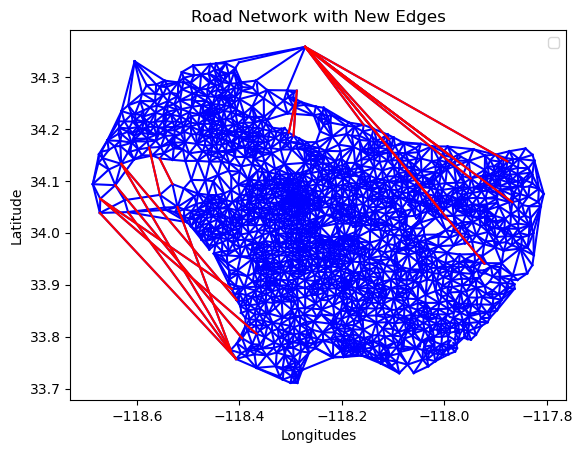

In [43]:
print_coordinates_and_plot(weighted_g1,
                           added_edge,
                           
                           longitudes=lons,
                           latitudes=lats,
                           save_path="figs/new_roads_q24.png")